In [78]:
import os
import numpy as np
from sklearn.cluster import MeanShift
from pathlib import Path
from matplotlib import pyplot as plt
import time
from skimage.segmentation import felzenszwalb
from skimage.color import gray2rgb
from sklearn.decomposition import PCA

In [79]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

In [80]:
# Load depth image and normalize it
depth_path = Path("input/01396.exr")
depth_im = cv2.imread(str(depth_path), cv2.IMREAD_ANYDEPTH)

max_mask = depth_im < 0.6
min_mask = depth_im > 0.1

mask =  max_mask * min_mask

maksed_depth_image = mask * depth_im


# mask_threshold[mask] = 1
# mask_threshold[~mask] = 0


# You might want to mask the depth image based on the target object's depth here
norm_depth_im = (255.0 * depth_im / depth_im.max()).astype(np.uint8)
norm_masked_depth_im = (255.0 * maksed_depth_image / maksed_depth_image.max()).astype(np.uint8)


In [81]:
def split_mask_using_pca(mask):
    assert len(mask.shape) == 2, "Input mask should be a 2D binary array"
    # uint_mask = mask.astype(np.uint8)
    # # Find contours in the binary mask
    # contours, _ = cv2.findContours(uint_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x_points, y_points = np.where(mask)
    points_of_interest = np.column_stack((x_points, y_points))
    # Extract contour points
    #points_of_interest = np.where(mask)
    contour_points = np.vstack(points_of_interest).squeeze()


    # Perform PCA on the contour points
    pca = PCA(n_components=2)
    pca.fit(contour_points)


    # Project contour points onto the first principal component
    projected_points = pca.transform(contour_points)[:, 0]

    # Find the median value of the projected points
    mean_point = np.mean(projected_points)

    # Separate points based on the median value
    points1 = contour_points[projected_points <= mean_point]
    points2 = contour_points[projected_points > mean_point]

    # Create two empty masks
    mask1 = np.zeros_like(mask)
    mask2 = np.zeros_like(mask)

    # Fill the two masks with separated points
    for pt in points1:
        mask1[pt[0], pt[1]] = 255

    for pt in points2:
        mask2[pt[0], pt[1]] = 255

    # Return the two masks
    return mask1, mask2


Computation took 3.11ms


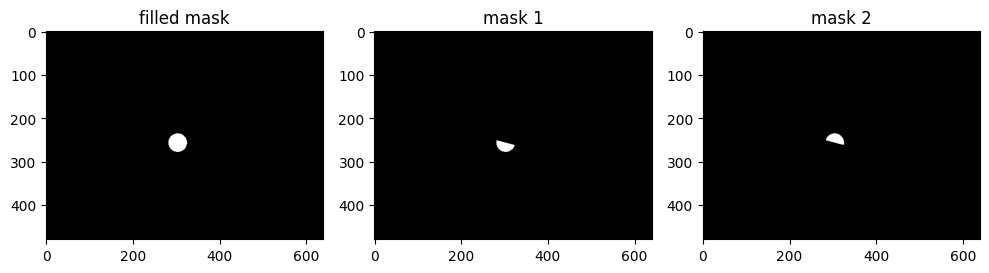

Computation took 217.37ms


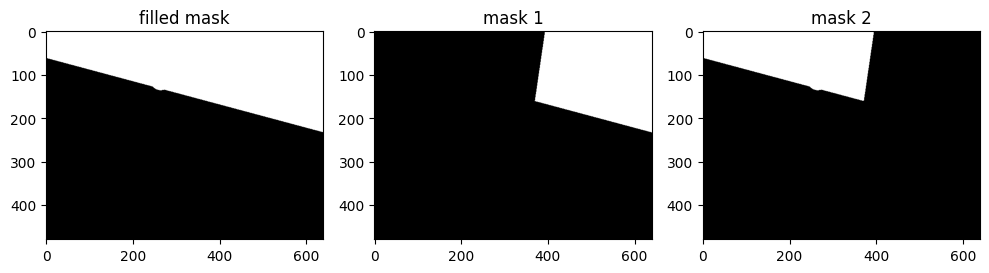

In [82]:
mask = mask.astype(np.uint8)
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for i, contour in enumerate(contours):
    # print(contour)
    # print(contour.shape)
    # calculate moments for each contour
    filled_mask = np.zeros_like(mask)

    # Draw the contours on the black mask
    cv2.drawContours(
        image=filled_mask,
        contours=[contour],
        contourIdx=0,
        color= 1,
        thickness = -1)
    
    filled_mask = filled_mask.astype(bool)
    image = filled_mask.astype(np.uint8) * 255
    
    





    # Split the binary mask using PCA
    start = time.time()
    mask1, mask2 = split_mask_using_pca(filled_mask)
    end = time.time()
    print(f"Computation took {1000.0 * (end - start):.2f}ms")
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('filled mask')

    ax[1].imshow(mask1 * 255, cmap='gray')
    ax[1].set_title('mask 1')

    ax[2].imshow(mask2, cmap='gray')
    ax[2].set_title('mask 2')

    plt.tight_layout()
    plt.show()



# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
# ax[0].imshow(image, cmap='gray')
# ax[0].set_title('filled mask')

# ax[1].imshow(mask1 * 255, cmap='gray')
# ax[1].set_title('mask 1')

# ax[2].imshow(mask2, cmap='gray')
# ax[2].set_title('mask 2')

# plt.tight_layout()
# plt.show()
    